This notebook is outdated -- for up-to-date stuff, see the notebooks `experiments`, `q_learning_tests`, and `piaget_demo`.

In [470]:
from __future__ import division

import gym
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim

import trackpy as tp
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy.misc
import os
%matplotlib inline
from trackpy.predict import NearestVelocityPredict

import cv2

In [471]:
import pdb
from time import sleep

import tensorflow.python.platform
from tensorflow.python.platform import gfile

from PIL import Image
import re

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier

In [472]:
from piaget import Point, Mover, MoverTracker, FramePair, Box, Categorizer
from piaget import init_env, play

In [473]:
env = gym.make('MsPacman-v0'); num_wait_steps=100;
#env = gym.make('Breakout-v0'); num_wait_steps = 1;
#env = gym.make('Assault-v0'); num_wait_steps = 1;

[2017-05-14 22:04:55,434] Making new env: MsPacman-v0


In [379]:
num_steps = 100
img_dir = 'img/'
mt = play(num_steps, env, img_dir, num_wait_steps)
fp = mt.frame_pairs
frame_thresh = [f.thresh for f in fp]

print mt.game_id

Frame 99: 1 trajectories present
907532


In [382]:
import matplotlib.colors as mcolors
box_colors_rgb = np.array([mcolors.hex2color(v) for v in mcolors.cnames.values()]).reshape((1,147, 3))
box_colors_hsv = mcolors.rgb_to_hsv(box_colors_rgb)
good_indices = (box_colors_hsv[0][:,1] > 0.5) & (box_colors_hsv[0][:,2] < 0.8)

box_colors = box_colors_rgb[0][good_indices]


 Frame: 0
Action: 5



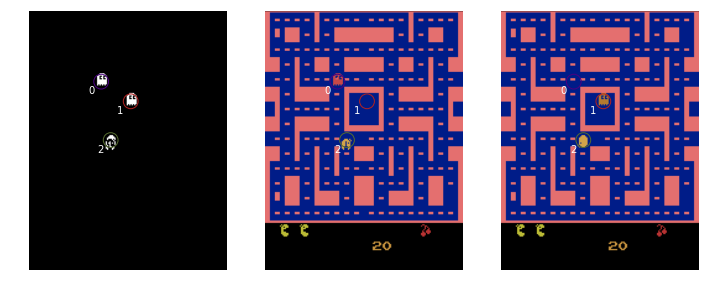


 Frame: 1
Action: 5



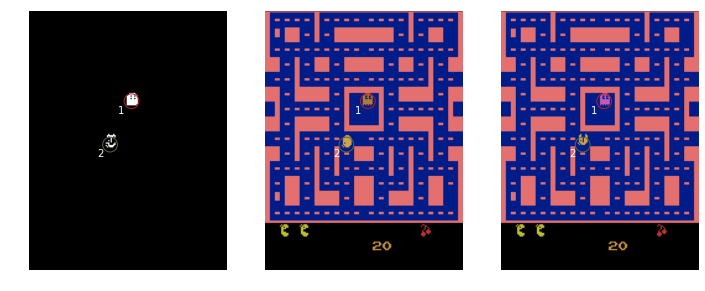


 Frame: 2
Action: 5



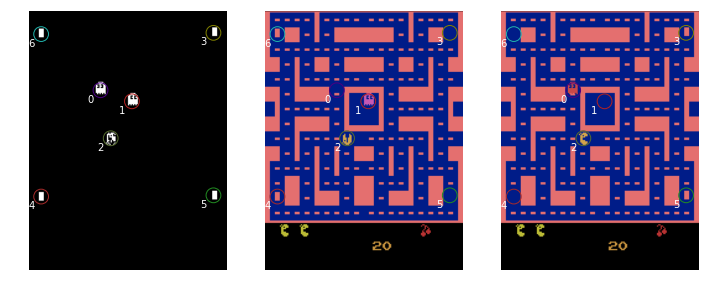


 Frame: 3
Action: 5



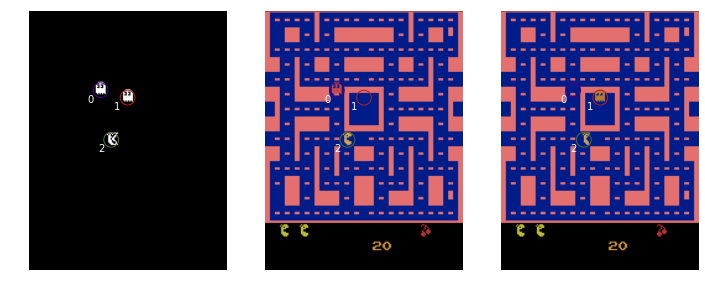


 Frame: 4
Action: 8



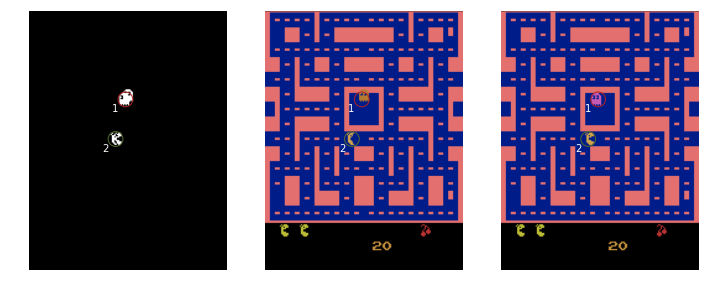


 Frame: 5
Action: 8



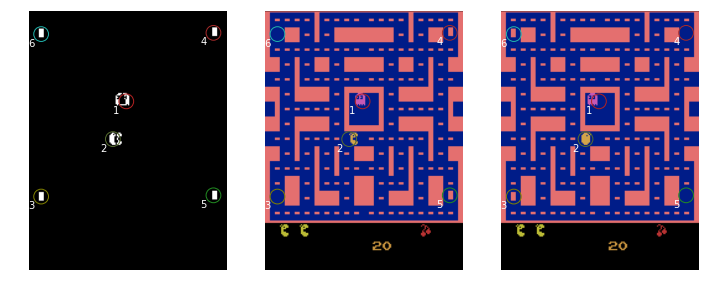


 Frame: 6
Action: 8



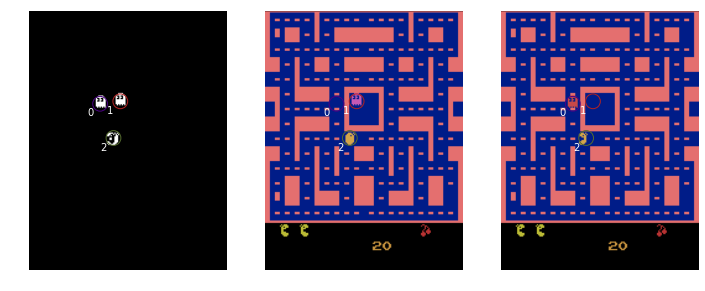


 Frame: 7
Action: 8



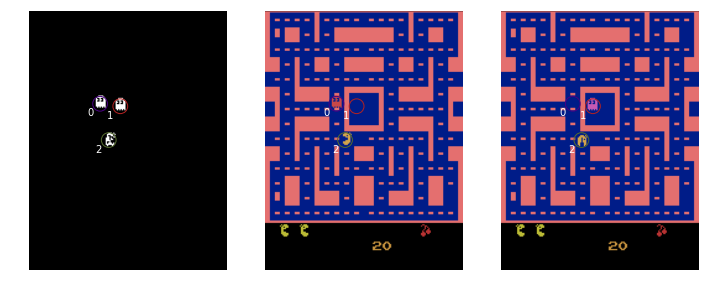


 Frame: 8
Action: 0



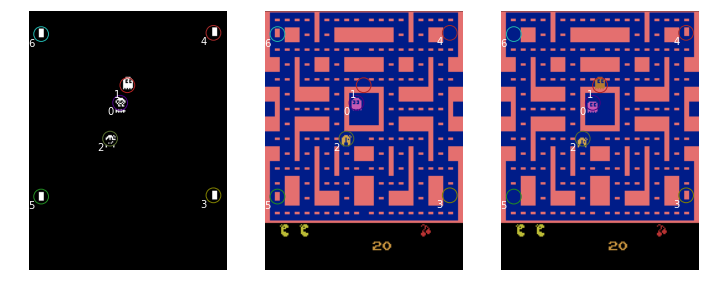


 Frame: 9
Action: 0



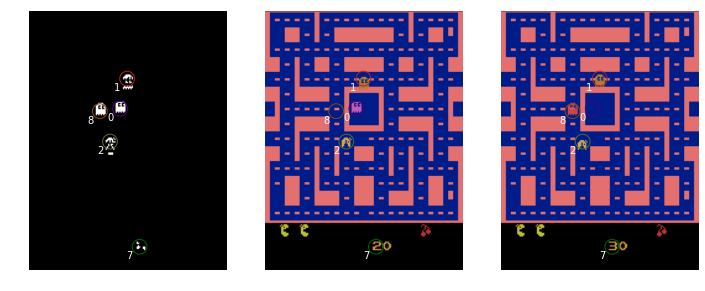


 Frame: 10
Action: 0



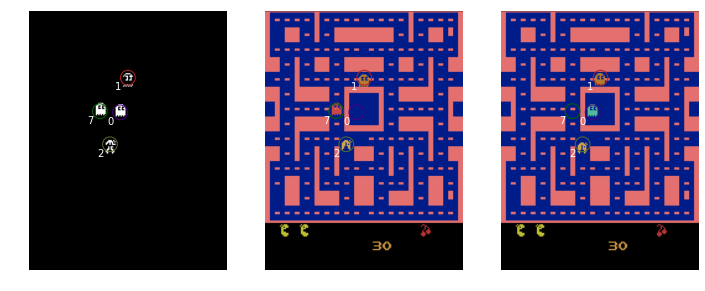


 Frame: 11
Action: 0



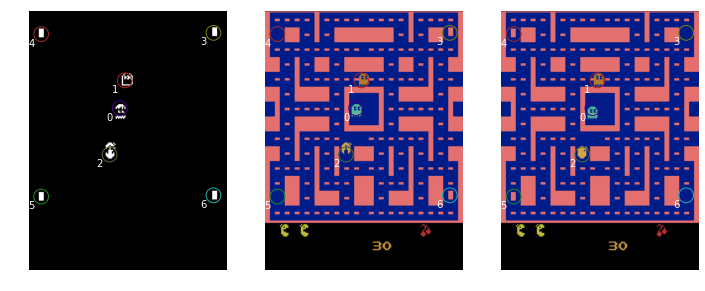


 Frame: 12
Action: 3



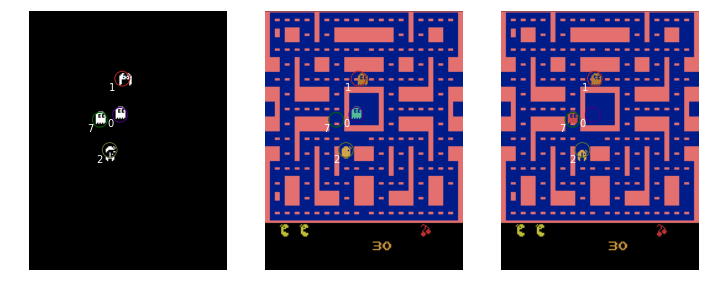


 Frame: 13
Action: 3



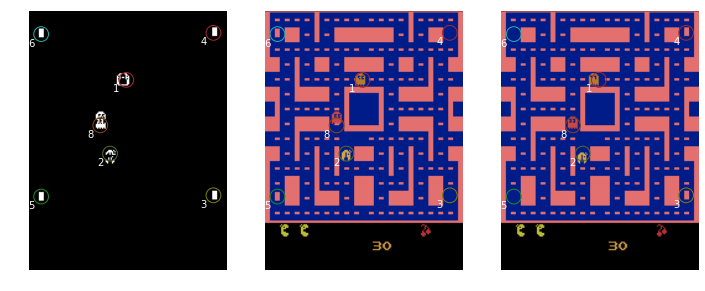


 Frame: 14
Action: 3



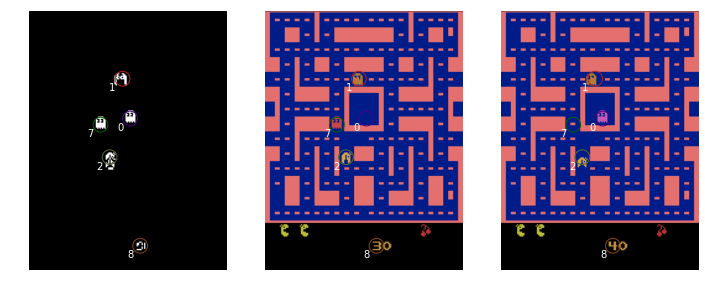


 Frame: 15
Action: 3



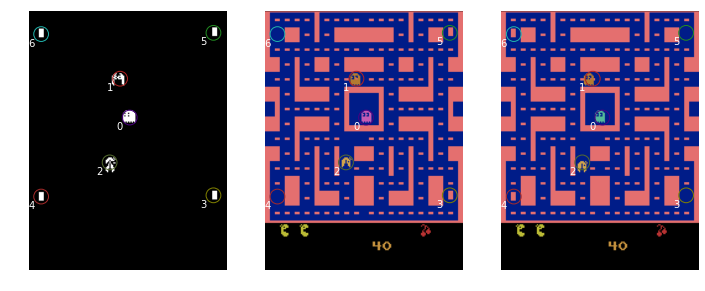


 Frame: 16
Action: 7



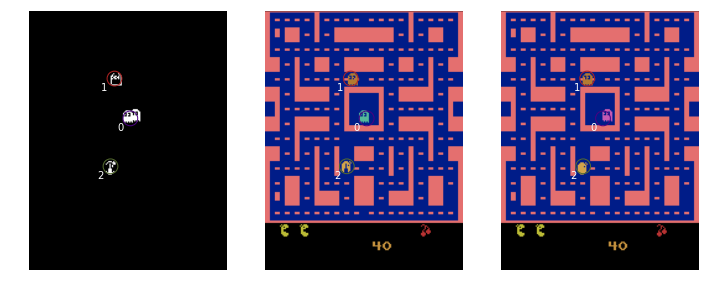


 Frame: 17
Action: 7



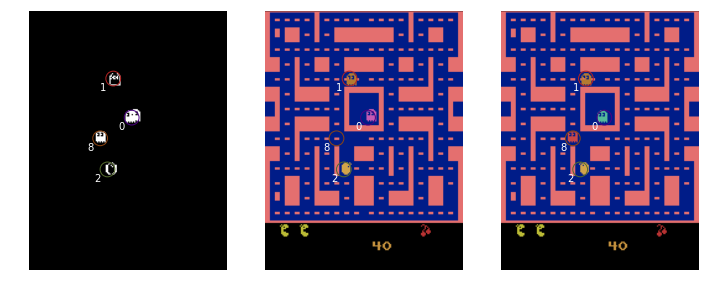


 Frame: 18
Action: 7



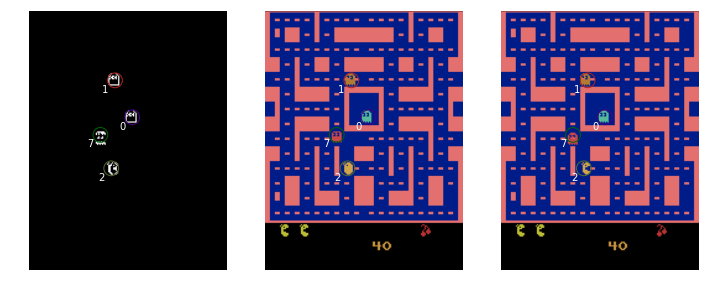


 Frame: 19
Action: 7



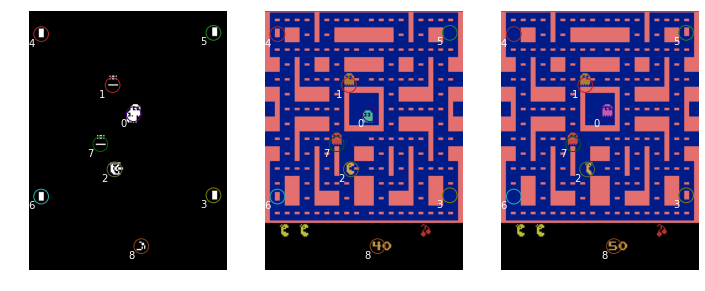

In [383]:
for i, thresh in enumerate(frame_thresh[:20]):
    print '\n Frame: ' + str(i)
    print 'Action: ' + str(mt.action_hist[i]) + '\n'
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(131)
    plt.axis('off')
    plt.imshow(thresh,cmap='gray')
    movers_cur_frame = []
    for m in mt.movers:
        cur_frame_pos = filter(lambda p: p[0]==i, m.trajectory)
        if len(cur_frame_pos) > 0:
            movers_cur_frame.append((m.id, cur_frame_pos[0][1]))
    for data in movers_cur_frame:
        m_id = data[0]
        pos = data[1]
        ax.add_patch(patches.Circle((pos.x, pos.y),
                                    radius=6,
                                    color=box_colors[m_id],
                                    fill=False)
            )
        plt.text(pos.x-10, pos.y+10, str(m_id),color='w')
        
    ax = fig.add_subplot(132)
    plt.axis('off')
    plt.imshow(fp[i].s0)
    for data in movers_cur_frame:
        m_id = data[0]
        pos = data[1]
        ax.add_patch(patches.Circle((pos.x, pos.y),
                                    radius=6,
                                    color=box_colors[m_id],
                                    fill=False)
            )
        plt.text(pos.x-10, pos.y+10, str(m_id),color='w')

    
    ax = fig.add_subplot(133)
    plt.axis('off')
    plt.imshow(fp[i].s1)
    for data in movers_cur_frame:
        m_id = data[0]
        pos = data[1]
        ax.add_patch(patches.Circle((pos.x, pos.y),
                                    radius=6,
                                    color=box_colors[m_id],
                                    fill=False)
            )
        plt.text(pos.x-10, pos.y+10, str(m_id),color='w')

    plt.show()

In [89]:
cat = Categorizer(mt.game_id, img_dir, mt.hyperparams)
cat.categorize_movers()

Processing img/640530/mover0/frame0.jpg...
Processing img/640530/mover1/frame19.jpg...
Processing img/640530/mover2/frame0.jpg...
Processing img/640530/mover2/frame2.jpg...
Processing img/640530/mover3/frame17.jpg...
Processing img/640530/mover4/frame9.jpg...
Processing img/640530/mover6/frame2.jpg...
Processing img/640530/mover7/frame9.jpg...
Processing img/640530/mover9/frame12.jpg...


In [90]:
LR=cat.LR
features=cat.features
labels=cat.labels

In [91]:
#np.random.shuffle
labels_rand = labels.copy()
np.random.shuffle(labels_rand)

In [92]:
LB = LabelBinarizer()
lb_labels = LB.fit_transform(labels)

for i in range(max(labels)+1):
    features_i = features[labels == i]
    labels_i = lb_labels[labels == i]
    features_rand_i = features[labels_rand == i]
    print i, 'size', len(labels_i)
    print i, 'log loss', log_loss(labels_i, LR.predict_proba(features_i))
    print i, 'score', LR.score(features_i, labels[labels == i])
    print i, 'rand', log_loss(labels_i, LR.predict_proba(features_rand_i)), '\n'

0 size 1
0 log loss 0.0971743715165
0 score 1.0
0 rand 7.24230329454 

1 size 17
1 log loss 0.352031406615
1 score 0.823529411765
1 rand 4.49630635326 

2 size 18
2 log loss 0.0242887911745
2 score 1.0
2 rand 4.72076265186 

3 size 8
3 log loss 1.48339014269
3 score 0.0
3 rand 4.81773982211 

4 size 5
4 log loss 1.91749616478
4 score 0.0
4 rand 5.02298556361 

5 size 5
5 log loss 1.34578556857
5 score 1.0
5 rand 6.46576599952 

6 size 8
6 log loss 1.48339014269
6 score 0.0
6 rand 2.75932884242 

7 size 7
7 log loss 1.26867143922
7 score 0.857142857143
7 rand 6.10820336524 

8 size 7
8 log loss 0.0644344664631
8 score 1.0
8 rand 4.67567578168 

9 size 10
9 log loss 0.043272082995
9 score 1.0
9 rand 4.42664856356 

10 size 1
10 log loss 0.0617759050414
10 score 1.0
10 rand 6.70443762637 

11 size 1
11 log loss 0.0737877281761
11 score 1.0
11 rand 6.78102707644 



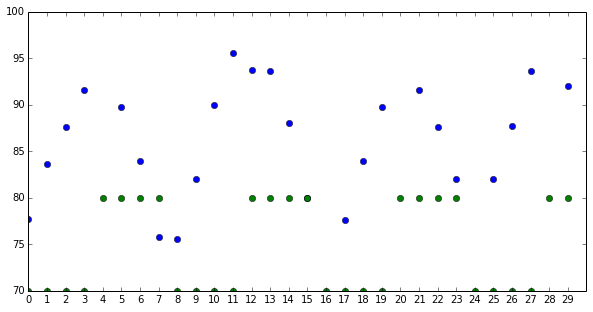

In [358]:
pac_traj = mt.movers[3].trajectory
plt.figure(figsize=(10,5))
plt.plot([p[0] for p in pac_traj], [p[1].x for p in pac_traj],'o')
plt.plot(40+10*np.array(mt.action_hist),'o')
plt.xticks(range(30));

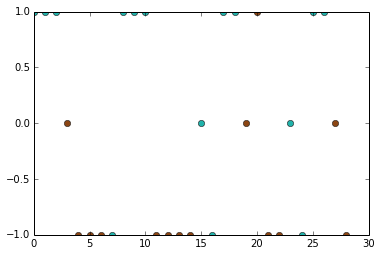

In [357]:
for i in range(len(mt.action_hist[1:])):
    plt.plot(i,features_actions.loc[i,'Mover 3: dir_x'],'o',
            color=box_colors[2*mt.action_hist[1+i]])

In [460]:
# messing around

def fill_trajectory(traj, num_frames):
    filled_traj = []
    for i in range(num_frames):
        relevant_positions = filter(lambda t: t[0] <= i, traj)
        if len(relevant_positions) == 0:
            #filled_traj.append(Point(None, None))
            filled_traj.append(Point(None, None))
        else:
            filled_traj.append(relevant_positions[-1][1])
    return filled_traj


test = mt.movers
traj = [t.trajectory for t in test]

disp = []
acc = []
feature_names = []

for i, tt in enumerate(traj):
    t = fill_trajectory(tt, len(mt.action_hist))

    disp_pts = [p2 - p1 for p2, p1 in zip(t[1:],t[:-1])]
    acc_pts = [p2 - p1 for p2, p1 in zip(disp_pts[1:],disp_pts[:-1])]
    disp_x = [p.x for p in disp_pts]
    disp_y = [p.y for p in disp_pts]
    acc_x = [p.x for p in acc_pts]
    acc_y = [p.y for p in acc_pts]

    disp_mag = [dx*dx + dy*dy \
                if dx is not None else None \
                for (dx, dy) in zip(disp_x, disp_y)]
    
    disp_dir_x = [np.sign(dx) \
                  if dx is not None else None \
                  for (dx, dy) in zip(disp_x, disp_y)]
    
    disp_dir_y = [np.sign(dy) \
                  if dy is not None else None \
                  for (dx, dy) in zip(disp_x, disp_y)]

    acc_mag = [dx*dx + dy*dy \
                if dx is not None else None \
                for (dx, dy) in zip(acc_x, acc_y)]
    
    acc_dir_x = [np.sign(dx) \
                  if dx is not None else None \
                  for (dx, dy) in zip(acc_x, acc_y)]
    
    acc_dir_y = [np.sign(dy) \
                  if dy is not None else None \
                  for (dx, dy) in zip(acc_x, acc_y)]

    #disp.append(disp_mag)
    disp.append(disp_dir_x)
    disp.append(disp_dir_y)
    acc.append(acc_mag)
    #acc.append(acc_dir_x)
    acc.append(acc_dir_y)
    
    #feature_names.append('Mover ' + str(i) + ': mag')
    feature_names.append('Mover ' + str(i) + ': dir_x')
    feature_names.append('Mover ' + str(i) + ': dir_y')
    
disp_features = np.array([np.concatenate([np.zeros(len(mt.action_hist[:-1])-len(d)), np.array(d)]) for d in disp]).T

acc_features = np.array([np.concatenate([np.zeros(len(mt.action_hist[:-1])-len(d)), np.array(d)]) for d in acc]).T

action_targets = np.array(mt.action_hist[1:])
features = acc_features

'''
LR2 = LogisticRegression(penalty='l1', C=0.1)
LR2.fit(features, action_targets)
print LR2.score(features, action_targets)
#plt.matshow(LR2.coef_,cmap='gray')
#plt.plot([LR2.score(features[i:i+5], action_targets[i:i+5]) for i in range(action_targets.shape[0]-5)])

plt.matshow(LR2.coef_[:,0::2],cmap='gray')
plt.colorbar()
plt.title('Coefficients: x coords')
plt.xticks(range(LR2.coef_[:,0::2].shape[1]))

plt.matshow(LR2.coef_[:,1::2],cmap='gray')
plt.colorbar()
plt.title('Coefficients: y coords')
plt.xticks(range(LR2.coef_[:,1::2].shape[1]))

LR3 = LogisticRegression(penalty='l1', C=0.5)
LR3.fit(features[400:], action_targets[400:])
print LR3.score(features[400:], action_targets[400:])
plt.matshow(LR3.coef_,cmap='gray')
plt.colorbar()
'''

"\nLR2 = LogisticRegression(penalty='l1', C=0.1)\nLR2.fit(features, action_targets)\nprint LR2.score(features, action_targets)\n#plt.matshow(LR2.coef_,cmap='gray')\n#plt.plot([LR2.score(features[i:i+5], action_targets[i:i+5]) for i in range(action_targets.shape[0]-5)])\n\nplt.matshow(LR2.coef_[:,0::2],cmap='gray')\nplt.colorbar()\nplt.title('Coefficients: x coords')\nplt.xticks(range(LR2.coef_[:,0::2].shape[1]))\n\nplt.matshow(LR2.coef_[:,1::2],cmap='gray')\nplt.colorbar()\nplt.title('Coefficients: y coords')\nplt.xticks(range(LR2.coef_[:,1::2].shape[1]))\n\nLR3 = LogisticRegression(penalty='l1', C=0.5)\nLR3.fit(features[400:], action_targets[400:])\nprint LR3.score(features[400:], action_targets[400:])\nplt.matshow(LR3.coef_,cmap='gray')\nplt.colorbar()\n"

action:  (5, 5)
num data pts:  12
Mover 0: dir_x     3.674347e+02
Mover 0: dir_y     2.651515e-01
Mover 1: dir_x     6.384496e+02
Mover 1: dir_y     8.106061e-01
Mover 2: dir_x     5.285165e+02
Mover 2: dir_y     9.318182e-01
Mover 3: dir_x     3.676751e+08
Mover 3: dir_y     7.666667e-01
Mover 4: dir_x     2.444235e+08
Mover 4: dir_y     2.777778e-01
Mover 5: dir_x     3.073122e+08
Mover 5: dir_y     8.444444e-01
Mover 6: dir_x     2.556231e+08
Mover 6: dir_y     4.444444e-01
Mover 7: dir_x     8.056681e+03
Mover 7: dir_y     9.888889e-01
Mover 8: dir_x     1.869866e+04
Mover 8: dir_y     2.222222e-01
Mover 9: dir_x     8.140732e+02
Mover 9: dir_y     9.888889e-01
Mover 10: dir_x    0.000000e+00
Mover 10: dir_y    0.000000e+00
Mover 11: dir_x    5.921211e+03
Mover 11: dir_y    6.666667e-01
Mover 12: dir_x    1.811058e+02
Mover 12: dir_y    6.666667e-01
dtype: float64


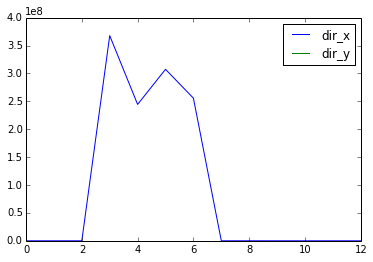

action:  (5, 8)
num data pts:  1
Series([], dtype: float64)


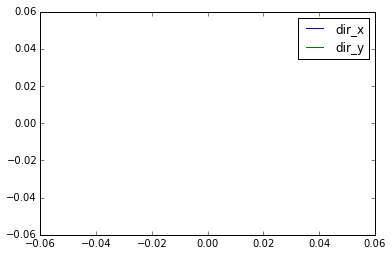

action:  (8, 8)
num data pts:  9
Mover 0: dir_x     2.625099e+03
Mover 0: dir_y     6.111111e-01
Mover 1: dir_x     1.080761e+03
Mover 1: dir_y     1.111111e+00
Mover 2: dir_x     1.499570e+02
Mover 2: dir_y     1.111111e+00
Mover 3: dir_x     2.403195e+08
Mover 3: dir_y     6.111111e-01
Mover 4: dir_x     2.587014e+08
Mover 4: dir_y     6.944444e-01
Mover 5: dir_x     9.012709e+07
Mover 5: dir_y     5.000000e-01
Mover 6: dir_x     1.885964e+08
Mover 6: dir_y     3.611111e-01
Mover 7: dir_x     2.049748e+03
Mover 7: dir_y     1.066667e+00
Mover 8: dir_x     2.645283e+07
Mover 8: dir_y     4.000000e-01
Mover 9: dir_x     3.073618e+01
Mover 9: dir_y     1.066667e+00
Mover 10: dir_x    0.000000e+00
Mover 10: dir_y    0.000000e+00
dtype: float64


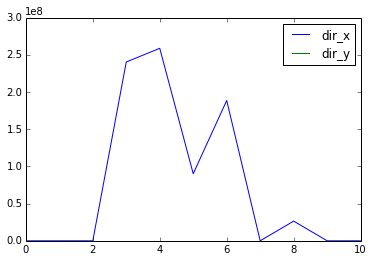

action:  (8, 0)
num data pts:  2
Mover 0: dir_x    3.527341e+04
Mover 0: dir_y    5.000000e-01
Mover 1: dir_x    9.038559e+04
Mover 1: dir_y    0.000000e+00
Mover 2: dir_x    8.615901e+01
Mover 2: dir_y    2.000000e+00
Mover 3: dir_x    0.000000e+00
Mover 3: dir_y    0.000000e+00
Mover 4: dir_x    0.000000e+00
Mover 4: dir_y    0.000000e+00
Mover 5: dir_x    2.369664e+06
Mover 5: dir_y    2.000000e+00
Mover 6: dir_x    6.952348e+08
Mover 6: dir_y    5.000000e-01
dtype: float64


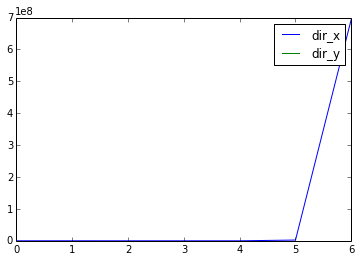

action:  (0, 0)
num data pts:  13
Mover 0: dir_x     6.788195e+03
Mover 0: dir_y     3.076923e-01
Mover 1: dir_x     2.774458e+03
Mover 1: dir_y     1.025641e+00
Mover 2: dir_x     1.914158e+02
Mover 2: dir_y     1.025641e+00
Mover 3: dir_x     1.731715e+08
Mover 3: dir_y     8.076923e-01
Mover 4: dir_x     2.121427e+08
Mover 4: dir_y     5.769231e-01
Mover 5: dir_x     4.295243e+08
Mover 5: dir_y     8.333333e-01
Mover 6: dir_x     2.063011e+08
Mover 6: dir_y     5.000000e-01
Mover 7: dir_x     1.571678e+07
Mover 7: dir_y     5.636364e-01
Mover 8: dir_x     0.000000e+00
Mover 8: dir_y     0.000000e+00
Mover 9: dir_x     9.631835e+01
Mover 9: dir_y     1.066667e+00
Mover 10: dir_x    0.000000e+00
Mover 10: dir_y    0.000000e+00
Mover 11: dir_x    1.142402e+03
Mover 11: dir_y    1.142857e+00
Mover 12: dir_x    3.790725e+00
Mover 12: dir_y    5.000000e-01
dtype: float64


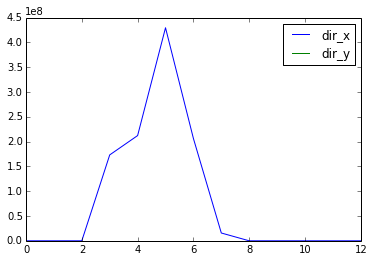

action:  (0, 3)
num data pts:  1
Series([], dtype: float64)


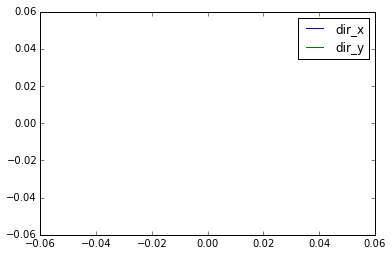

action:  (3, 3)
num data pts:  6
Mover 0: dir_x     1.573742e+03
Mover 0: dir_y     5.666667e-01
Mover 1: dir_x     3.134693e+02
Mover 1: dir_y     1.066667e+00
Mover 2: dir_x     3.174625e+03
Mover 2: dir_y     1.066667e+00
Mover 3: dir_x     9.233791e+07
Mover 3: dir_y     8.000000e-01
Mover 4: dir_x     2.294287e+09
Mover 4: dir_y     1.200000e+00
Mover 5: dir_x     2.126189e+08
Mover 5: dir_y     6.666667e-01
Mover 6: dir_x     3.603656e+08
Mover 6: dir_y     8.000000e-01
Mover 7: dir_x     3.648975e+02
Mover 7: dir_y     5.666667e-01
Mover 8: dir_x     2.462059e+07
Mover 8: dir_y     5.666667e-01
Mover 9: dir_x     1.388213e+04
Mover 9: dir_y     1.000000e+00
Mover 10: dir_x    0.000000e+00
Mover 10: dir_y    0.000000e+00
Mover 11: dir_x    9.757404e+03
Mover 11: dir_y    1.333333e+00
Mover 12: dir_x    0.000000e+00
Mover 12: dir_y    0.000000e+00
dtype: float64


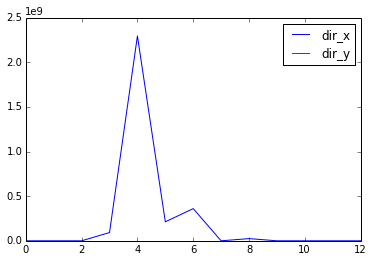

action:  (3, 7)
num data pts:  1
Series([], dtype: float64)


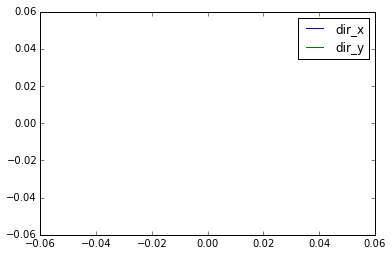

action:  (7, 7)
num data pts:  19
Mover 0: dir_x     1.493625e+02
Mover 0: dir_y     4.736842e-01
Mover 1: dir_x     4.117111e+02
Mover 1: dir_y     8.304094e-01
Mover 2: dir_x     2.566792e+02
Mover 2: dir_y     6.666667e-01
Mover 3: dir_x     2.279637e+08
Mover 3: dir_y     6.666667e-01
Mover 4: dir_x     2.992846e+08
Mover 4: dir_y     5.555556e-01
Mover 5: dir_x     1.979018e+08
Mover 5: dir_y     4.970760e-01
Mover 6: dir_x     2.491178e+08
Mover 6: dir_y     6.549708e-01
Mover 7: dir_x     1.941646e+03
Mover 7: dir_y     6.081871e-01
Mover 8: dir_x     1.351133e+07
Mover 8: dir_y     3.859649e-01
Mover 9: dir_x     1.079706e+03
Mover 9: dir_y     8.333333e-01
Mover 10: dir_x    0.000000e+00
Mover 10: dir_y    0.000000e+00
Mover 11: dir_x    3.089006e+01
Mover 11: dir_y    1.142857e+00
Mover 12: dir_x    2.138848e-01
Mover 12: dir_y    3.333333e-01
dtype: float64


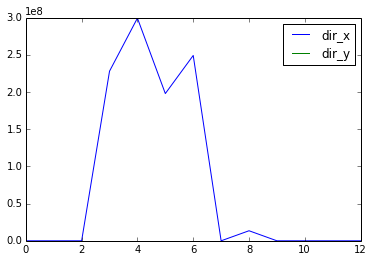

action:  (7, 1)
num data pts:  1
Series([], dtype: float64)


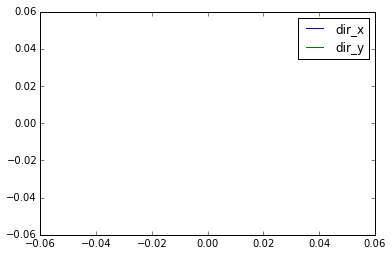

action:  (1, 1)
num data pts:  9
Mover 0: dir_x     2.735005e+03
Mover 0: dir_y     3.611111e-01
Mover 1: dir_x     4.688704e+02
Mover 1: dir_y     1.111111e+00
Mover 2: dir_x     2.409151e+02
Mover 2: dir_y     1.000000e+00
Mover 3: dir_x     1.878632e+08
Mover 3: dir_y     6.944444e-01
Mover 4: dir_x     2.319116e+08
Mover 4: dir_y     6.111111e-01
Mover 5: dir_x     2.361178e+08
Mover 5: dir_y     7.500000e-01
Mover 6: dir_x     2.336948e+08
Mover 6: dir_y     6.111111e-01
Mover 7: dir_x     1.483778e+02
Mover 7: dir_y     3.611111e-01
Mover 8: dir_x     1.538041e+07
Mover 8: dir_y     4.444444e-01
Mover 9: dir_x     9.354625e+02
Mover 9: dir_y     1.200000e+00
Mover 10: dir_x    0.000000e+00
Mover 10: dir_y    0.000000e+00
Mover 11: dir_x    5.211143e+03
Mover 11: dir_y    1.000000e+00
Mover 12: dir_x    1.112452e+00
Mover 12: dir_y    3.333333e-01
dtype: float64


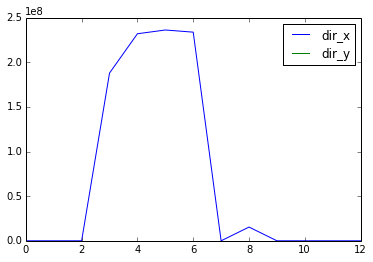

action:  (1, 7)
num data pts:  2
Mover 0: dir_x    4.258606e+01
Mover 0: dir_y    5.000000e-01
Mover 1: dir_x    7.632426e-07
Mover 1: dir_y    0.000000e+00
Mover 2: dir_x    4.259109e+02
Mover 2: dir_y    5.000000e-01
Mover 3: dir_x    7.696515e+00
Mover 3: dir_y    5.000000e-01
Mover 4: dir_x    6.756856e+08
Mover 4: dir_y    5.000000e-01
Mover 5: dir_x    1.393920e+05
Mover 5: dir_y    2.000000e+00
Mover 6: dir_x    2.619204e+07
Mover 6: dir_y    2.000000e+00
Mover 7: dir_x    3.878246e+02
Mover 7: dir_y    5.000000e-01
Mover 8: dir_x    7.975448e+00
Mover 8: dir_y    0.000000e+00
dtype: float64


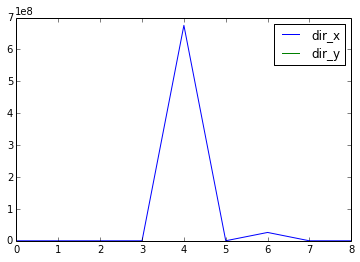

action:  (7, 8)
num data pts:  1
Series([], dtype: float64)


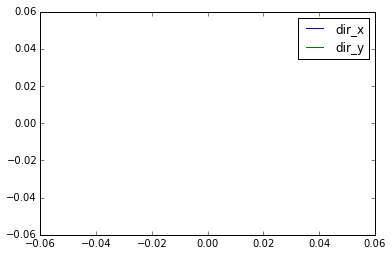

action:  (0, 7)
num data pts:  1
Series([], dtype: float64)


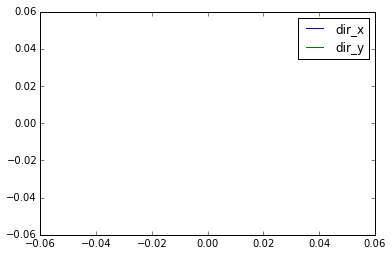

action:  (7, 5)
num data pts:  2
Mover 0: dir_x    2.724732e+01
Mover 0: dir_y    5.000000e-01
Mover 1: dir_x    9.542496e-09
Mover 1: dir_y    2.000000e+00
Mover 2: dir_x    1.202353e+02
Mover 2: dir_y    2.000000e+00
Mover 3: dir_x    1.920996e+08
Mover 3: dir_y    5.000000e-01
Mover 4: dir_x    1.564327e+08
Mover 4: dir_y    0.000000e+00
Mover 5: dir_x    1.564657e+08
Mover 5: dir_y    0.000000e+00
Mover 6: dir_x    1.869598e+08
Mover 6: dir_y    2.000000e+00
Mover 7: dir_x    4.421901e+00
Mover 7: dir_y    2.000000e+00
Mover 8: dir_x    4.201938e+03
Mover 8: dir_y    2.000000e+00
Mover 9: dir_x    1.092140e+00
Mover 9: dir_y    0.000000e+00
dtype: float64


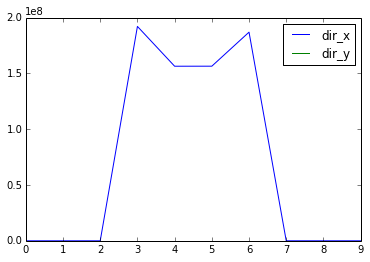

action:  (5, 6)
num data pts:  2
Mover 0: dir_x    0.000000e+00
Mover 0: dir_y    0.000000e+00
Mover 1: dir_x    3.288109e+03
Mover 1: dir_y    0.000000e+00
Mover 2: dir_x    7.496370e+00
Mover 2: dir_y    0.000000e+00
Mover 3: dir_x    0.000000e+00
Mover 3: dir_y    2.000000e+00
Mover 4: dir_x    1.130788e+08
Mover 4: dir_y    0.000000e+00
Mover 5: dir_x    1.195835e+08
Mover 5: dir_y    0.000000e+00
Mover 6: dir_x    0.000000e+00
Mover 6: dir_y    0.000000e+00
Mover 7: dir_x    0.000000e+00
Mover 7: dir_y    0.000000e+00
Mover 8: dir_x    4.185214e+01
Mover 8: dir_y    0.000000e+00
Mover 9: dir_x    4.011552e+01
Mover 9: dir_y    2.000000e+00
dtype: float64


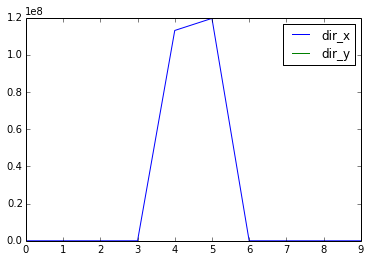

action:  (6, 6)
num data pts:  9
Mover 0: dir_x     0.000000e+00
Mover 0: dir_y     0.000000e+00
Mover 1: dir_x     1.054646e+03
Mover 1: dir_y     1.000000e+00
Mover 2: dir_x     6.486951e+02
Mover 2: dir_y     7.777778e-01
Mover 3: dir_x     1.898849e+09
Mover 3: dir_y     7.500000e-01
Mover 4: dir_x     2.539428e+08
Mover 4: dir_y     8.611111e-01
Mover 5: dir_x     1.456977e+08
Mover 5: dir_y     7.500000e-01
Mover 6: dir_x     1.290989e+08
Mover 6: dir_y     5.277778e-01
Mover 7: dir_x     2.517375e+02
Mover 7: dir_y     4.444444e-01
Mover 8: dir_x     4.023625e+03
Mover 8: dir_y     1.944444e-01
Mover 9: dir_x     4.971882e+02
Mover 9: dir_y     1.000000e+00
Mover 10: dir_x    0.000000e+00
Mover 10: dir_y    0.000000e+00
Mover 11: dir_x    6.639512e+03
Mover 11: dir_y    9.666667e-01
Mover 12: dir_x    4.025655e+02
Mover 12: dir_y    4.000000e-01
dtype: float64


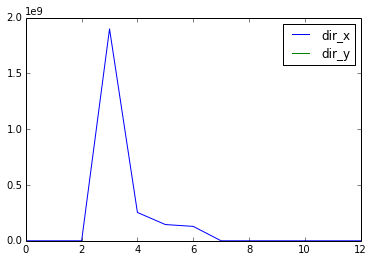

action:  (6, 8)
num data pts:  1
Series([], dtype: float64)


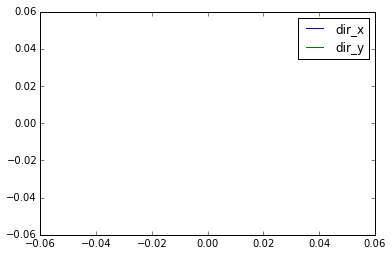

action:  (8, 7)
num data pts:  1
Series([], dtype: float64)


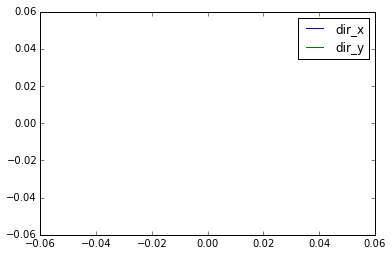

action:  (5, 1)
num data pts:  1
Series([], dtype: float64)


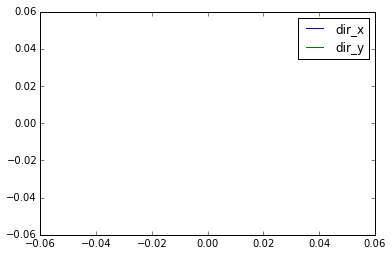

action:  (1, 0)
num data pts:  1
Series([], dtype: float64)


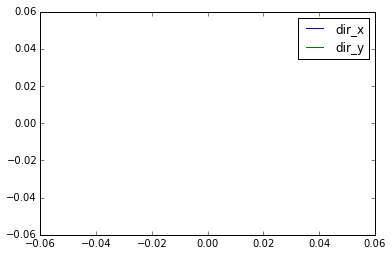

action:  (0, 5)
num data pts:  1
Series([], dtype: float64)


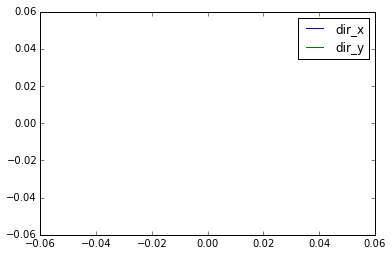

action:  (6, 3)
num data pts:  1
Series([], dtype: float64)


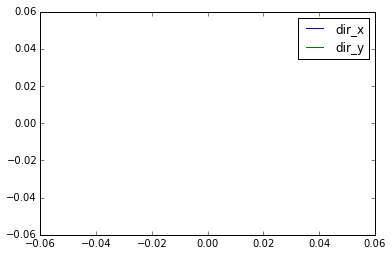

action:  (3, 6)
num data pts:  1
Series([], dtype: float64)


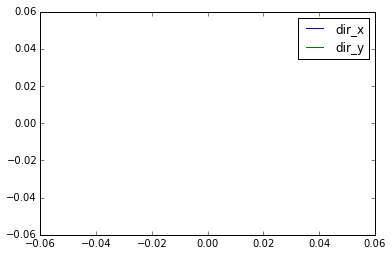

action:  (6, 1)
num data pts:  1
Series([], dtype: float64)


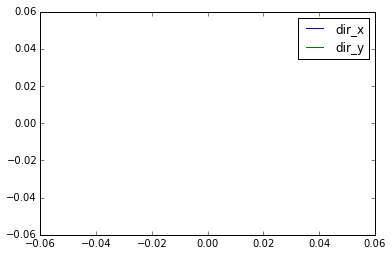

In [465]:
features_actions = pd.DataFrame(features,columns=feature_names)
features_var = features_actions.var()
features_actions['action'] = [(a,b) for a,b in zip(mt.action_hist[:-1],mt.action_hist[1:])]

import warnings
warnings.filterwarnings("ignore")

a_vars = []
plot_a_vars = True
for a in pd.unique(features_actions['action']):
    print 'action: ', a
    print 'num data pts: ', features_actions.groupby('action')['action'].count()[a]
    no_data_filter = features_actions[features_actions['action']==a].count()>1
    no_data_filter = no_data_filter.drop('action')
    a_var = features_actions[features_actions['action']==a].drop('action',axis=1).loc[:,no_data_filter].var()
    #reference_var = features_var.loc[no_data_filter]
    #var_imps.append((reference_var - a_var) / reference_var)
    a_vars.append(a_var)
    if plot_a_vars:
        print a_vars[-1]
        plt.plot(a_vars[-1][0::2],label='dir_x')
        plt.legend()
        plt.plot(a_vars[-1][1::2],label='dir_y')
        plt.legend()
        plt.show()

In [464]:
print features_var / pd.concat(a_vars, axis=1).mean(axis=1)

Mover 0: dir_x     0.502008
Mover 0: dir_y     0.989083
Mover 10: dir_x         NaN
Mover 10: dir_y         NaN
Mover 11: dir_x    0.915914
Mover 11: dir_y    0.849747
Mover 12: dir_x    1.615757
Mover 12: dir_y    0.976934
Mover 1: dir_x     0.327329
Mover 1: dir_y     1.152581
Mover 2: dir_x     1.434113
Mover 2: dir_y     0.899074
Mover 3: dir_x     1.195554
Mover 3: dir_y     0.890267
Mover 4: dir_x     0.944308
Mover 4: dir_y     1.324333
Mover 5: dir_x     1.710308
Mover 5: dir_y     0.829420
Mover 6: dir_x     1.013713
Mover 6: dir_y     0.763942
Mover 7: dir_x     1.224840
Mover 7: dir_y     0.861823
Mover 8: dir_x     1.220458
Mover 8: dir_y     0.772989
Mover 9: dir_x     0.724135
Mover 9: dir_y     0.898208
dtype: float64


In [387]:
plt.plot(np.array(sum(var_imps)[0::2]) + np.array(sum(var_imps)[1::2]))

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan])

In [ ]:
DT = DecisionTreeClassifier()
DT = DT.fit(features, action_targets)
DT.score(features, action_targets)

In [151]:
f = export_graphviz(DT, out_file='tree.dot', feature_names=feature_names)
f.close()

In [197]:
RF = RandomForestClassifier(max_depth=3)
RF = RF.fit(features, action_targets)
RF.score(features, action_targets)

0.78947368421052633

In [198]:
for i in range(len(RF.feature_importances_)):
    print feature_names[i] + '\t' + str(RF.feature_importances_[i])

Mover 0: x	0.0
Mover 0: y	0.0
Mover 1: x	0.163964644008
Mover 1: y	0.156608207302
Mover 2: x	0.0288598027853
Mover 2: y	0.110153283663
Mover 3: x	0.0398369105128
Mover 3: y	0.0474381677344
Mover 4: x	0.0223540417384
Mover 4: y	0.0347157830402
Mover 5: x	0.0
Mover 5: y	0.0
Mover 6: x	0.0440401428341
Mover 6: y	0.0628645149525
Mover 7: x	0.0268513786992
Mover 7: y	0.0473025150242
Mover 8: x	0.0
Mover 8: y	0.0782779960268
Mover 9: x	0.0487783229945
Mover 9: y	0.0879542886839
Mover 10: x	0.0
Mover 10: y	0.0
Mover 11: x	0.0
Mover 11: y	0.0


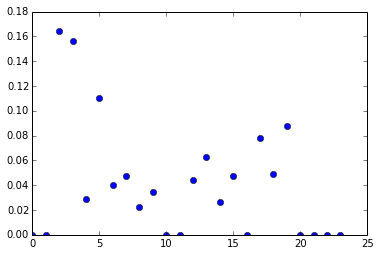

In [199]:
plt.plot(RF.feature_importances_,'o')

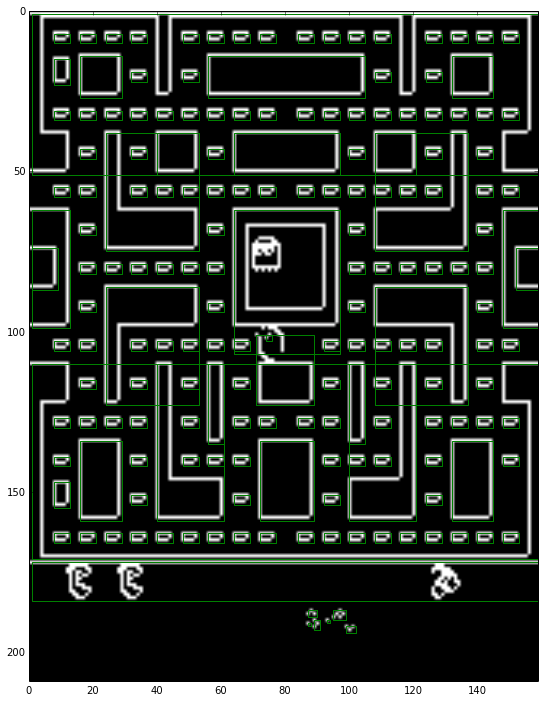

In [501]:
plt.figure(figsize=(12,12))
plt.imshow(edge_thresh,cmap='gray')
ax = plt.gca()
plt.axis([0, 159, 209, 0])
for i, c in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)
    ax.add_patch(patches.Rectangle((x,y),w,h,color='g',fill=False))
plt.show()

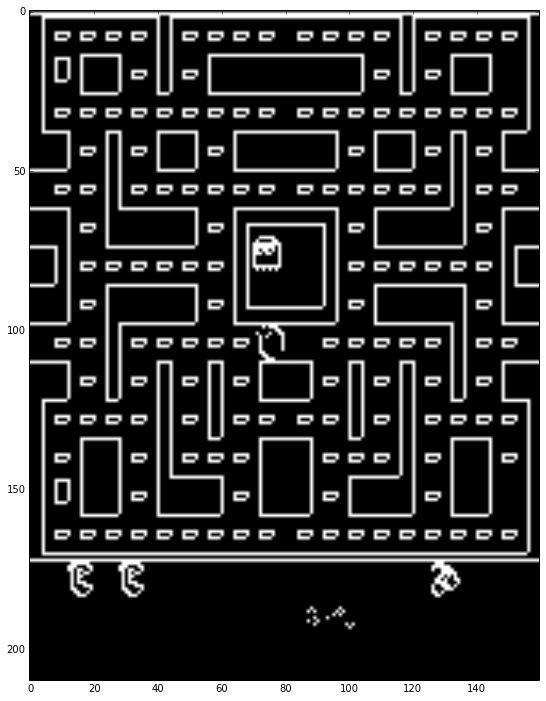

In [507]:
plt.figure(figsize=(12,12))
edge_thresh = cv2.threshold(edge_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
plt.imshow(edge_thresh,cmap='gray')
(cnts, hierarchy) = \
    cv2.findContours(edge_thresh.copy(), 
                     cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

0


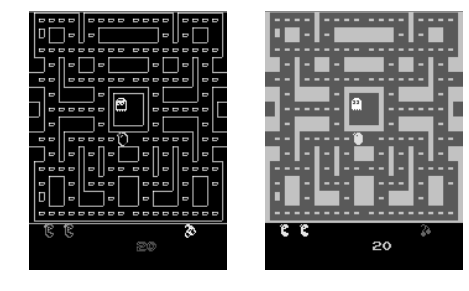

In [481]:
#ksize = 1
#sobel_x = cv2.Sobel(frame_gray, cv2.CV_64F, 1, 0, ksize)
#sobel_y = cv2.Sobel(frame_gray, cv2.CV_64F, 0, 1, ksize)

#raw_edges = np.sqrt(sobel_x**2 + sobel_y**2)

frame_channels = [frame_color[:,:,i] for i in [0,1,2]]

simple_x = []
simple_y = []

for ch in frame_channels:
    padded_x = np.pad(ch,((0,0),(1,0)),'edge')
    padded_y = np.pad(ch,((1,0),(0,0)),'edge')

    simple_x.append(padded_x[:,1:] - padded_x[:,:-1])
    simple_y.append(padded_y[1:,:] - padded_y[:-1,:])

simple_x = np.array(simple_x)    
simple_y = np.array(simple_y)    

raw_edges_float = np.sqrt(sum(simple_x**2) + sum(simple_y**2))
raw_edges_float = raw_edges_float * (255. / np.max(raw_edges_float))

raw_edges = raw_edges_float.astype('uint8')

shift = -1*np.min(raw_edges)
edge_img = (raw_edges + shift)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.axis('off')
plt.imshow(edge_img,cmap='gray')
plt.subplot(132)
plt.axis('off')
plt.imshow(frame_gray, cmap='gray')
print shift

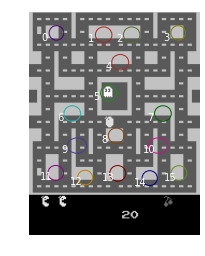

In [380]:
frame_color = fp[5].s0
frame_gray = cv2.cvtColor(fp[5].s0, cv2.COLOR_BGR2GRAY)
particles = tp.locate(frame_gray, 25)

plt.imshow(frame_gray, cmap='gray')
ax = plt.gca()
plt.axis([0,frame_gray.shape[1]-1,frame_gray.shape[0]-1,0])
plt.axis('off')

for row in particles.iterrows():
    pos = Point(row[1]['x'], row[1]['y'])
    m_id = row[0]
    size = row[1]['size']
    ecc = row[1]['ecc']
    width = 1./np.sqrt(1-ecc**2) * size
    height = size
    ax.add_patch(patches.Ellipse((pos.x+size/2, pos.y+size/2),
                                 2*width, 2*height,
                                color=box_colors[m_id],
                                fill=False)
        )
    plt.text(pos.x-10, pos.y+10, str(m_id),color='w')
